# 4.9 - Atrous convolutions

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
print (tf.__version__)

def dilate(simg):
    k = simg.copy()
    for i in range(k.shape[1]-1):
        k = np.insert(k, 1+2*i, values=0, axis=1)
    for i in range(k.shape[0]-1):
        k = np.insert(k, 1+2*i, values=0, axis=0)
    return k

2.4.1


See [Types of convolutions](https://medium.com/hitchhikers-guide-to-deep-learning/10-introduction-to-deep-learning-with-computer-vision-types-of-convolutions-atrous-convolutions-3cf142f77bc0) for a global view of how convolutions can be made in different ways.

**Atrous convolutions** are done through dilation on the **filter** (not on the image as in transposed convolutions)

This is implemented in the same `Conv2D` layer through the `dilation_rate` argument.

The goal is that with the **same** filter, one could capture a larger **receptive field** and thus, doing an operation at a smaller resolution while keeping some detail.

In [35]:
simg = np.r_[[[4,5,8,7],[1,8,8,8],[3,6,6,4],[6,5,7,8]]].astype(np.float32)
kernel = np.r_[[[10,-8],[15,-2]]]

In [36]:
ddkernel = dilate(kernel)
print ("filter\n", kernel)
print ("dilated filter\n", ddkernel)

filter
 [[10 -8]
 [15 -2]]
dilated filter
 [[10  0 -8]
 [ 0  0  0]
 [15  0 -2]]


regular convolution

In [37]:
c1 = tf.keras.layers.Conv2D(filters=1, kernel_size=kernel.shape, padding="VALID", activation="linear")
c1.build(input_shape=[None, *simg[:,:,None].shape])
c1.set_weights([kernel.T[:,:,None, None], np.r_[0]])
c1(simg.T[None, :, :, None]).numpy().T[0,:,:,0]

array([[ -1.,  90., 128.],
       [-21.,  94.,  98.],
       [ 62.,  73., 117.]], dtype=float32)

dilated convolution

In [38]:
c1 = tf.keras.layers.Conv2D(filters=1, kernel_size=ddkernel.shape, padding="VALID", activation="linear")
c1.build(input_shape=[None, *simg[:,:,None].shape])
c1.set_weights([ddkernel.T[:,:,None, None], np.r_[0]])
c1(simg.T[None, :, :, None]).numpy().T[0,:,:,0]

array([[ 9., 76.],
       [22., 75.]], dtype=float32)

observe how the receptive field of the dilated filter (3z3) **is larger** than the original filter (2x2)

In [39]:
(simg[:2,:2]*kernel).sum() # corresponds to the (0,0) regular convolution output

-1.0

In [40]:
(simg[:3,:3]*ddkernel).sum() # corresponds to the (0,0) dilated convolution output

9.0

observe we obtain the same result by using `dilation_rate=1`

In [41]:
c1 = tf.keras.layers.Conv2D(filters=1, kernel_size=ddkernel.shape, padding="VALID", activation="linear")
c1.build(input_shape=[None, *simg[:,:,None].shape])
c1.set_weights([ddkernel.T[:,:,None, None], np.r_[0]])
c1(simg.T[None, :, :, None]).numpy().T[0,:,:,0]

array([[ 9., 76.],
       [22., 75.]], dtype=float32)

In [42]:
simg

array([[4., 5., 8., 7.],
       [1., 8., 8., 8.],
       [3., 6., 6., 4.],
       [6., 5., 7., 8.]], dtype=float32)

### Intuition

somehow, with atrous convolutions we are using a **lower resolution filter** at a higher resolution image, with the hope to extract semantic content while keeping some details

In [47]:
from skimage import io
img = io.imread("local/imgs/sample_img.png")
img = (img-np.min(img))/(np.max(img)-np.min(img))
img = img.reshape(1,*img.shape, 1)
f = np.r_[[-1., -1.,  1., -1., -1., -1., -1.,  1.,  1.],
          [ 1., -1.,  1., -1., -1.,  1., -1., -1., -1.]].reshape(3,3,1,2)

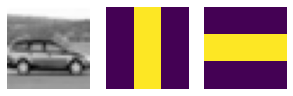

In [48]:
plt.figure(figsize=(5,2))
plt.subplot(131);  plt.imshow(img[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off")
plt.subplot(132);  plt.imshow(f[:,:,0,0]); plt.axis("off")
plt.subplot(133);  plt.imshow(f[:,:,0,1]); plt.axis("off");

observe the regular convolution at the original resolution

(1, 30, 30, 2)


Text(0.5, 1.0, 'conv filter 1')

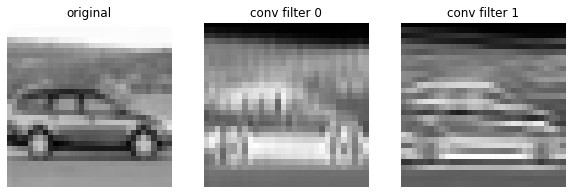

In [49]:
c = tf.keras.layers.Conv2D(filters=f.shape[-1], kernel_size=f.shape[:2], activation="sigmoid", padding='VALID', dtype=tf.float64)
c.build(input_shape=(1,7,7,f.shape[2]))   # any shape would do here, just initializing weights
c.set_weights([f, np.zeros(2)])
cimg = c(img).numpy()
print (cimg.shape)
plt.figure(figsize=(10,6))
plt.subplot(131); plt.imshow(img[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("original")
plt.subplot(132); plt.imshow(cimg[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("conv filter 0")
plt.subplot(133); plt.imshow(cimg[0,:,:,1], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("conv filter 1")


now a dilated convolution, think of applying the same filter at a lower resolution while keeping details

(1, 28, 28, 2)


Text(0.5, 1.0, 'conv filter 1')

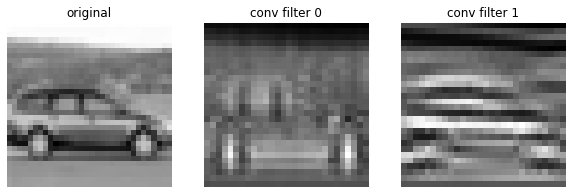

In [79]:
c = tf.keras.layers.Conv2D(filters=f.shape[-1], kernel_size=f.shape[:2], 
                           dilation_rate=2,
                           activation="sigmoid", padding='VALID', dtype=tf.float64)
c.build(input_shape=(1,7,7,f.shape[2]))   # any shape would do here, just initializing weights
c.set_weights([f, np.zeros(2)])
cimg = c(img).numpy()
print (cimg.shape)

plt.figure(figsize=(10,6))
plt.subplot(131); plt.imshow(img[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("original")
plt.subplot(132); plt.imshow(cimg[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("conv filter 0")
plt.subplot(133); plt.imshow(cimg[0,:,:,1], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("conv filter 1")


now we actually resize the image **and THEN** apply the original filter (with no dilution), so that the final resolution is the same

However, observe how the previous dilated convolutions tries to keep sharper details of the original image 

In [82]:
from skimage.transform import resize
n = 30
simg = resize(img[0,:,:,0], (n, n)).reshape(1,n,n,1)
simg.shape

(1, 30, 30, 1)

(1, 28, 28, 2)


Text(0.5, 1.0, 'conv filter 1')

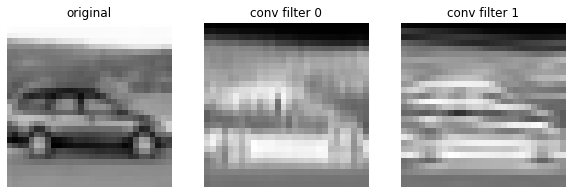

In [83]:
c = tf.keras.layers.Conv2D(filters=f.shape[-1], kernel_size=f.shape[:2], activation="sigmoid", padding='VALID', dtype=tf.float64)
c.build(input_shape=(1,7,7,f.shape[2]))   # any shape would do here, just initializing weights
c.set_weights([f, np.zeros(2)])
csimg = c(simg).numpy()
print(csimg.shape)

plt.figure(figsize=(10,6))
plt.subplot(131); plt.imshow(simg[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("original")
plt.subplot(132); plt.imshow(csimg[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("conv filter 0")
plt.subplot(133); plt.imshow(csimg[0,:,:,1], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("conv filter 1")
